In [5]:
# import all lib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.feature_selection import VarianceThreshold

In [6]:
# Dataset
df = pd.read_csv('patient_data.csv')

display(df.head())
print(f"\033[1mInference:\033[0m The shape of data is {df.shape}")

,PatientID,Gender,Age,CholesterolLevel,BloodPressure,Region,RiskCategory
0,1,Male,37,193.4,129.4,East,High
1,2,Female,45,210.7,107.1,West,Low
2,3,Male,63,244.3,103.9,West,Low
3,4,Male,53,184.5,127.2,West,High
4,5,Male,29,175.7,116.6,South,High


Inference: The shape of data is (100, 7)


In [7]:
df.info()
print(f"\003[1minference:003[0m Data seem to be free from null values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PatientID         100 non-null    int64  
 1   Gender            100 non-null    object 
 2   Age               100 non-null    int64  
 3   CholesterolLevel  100 non-null    float64
 4   BloodPressure     100 non-null    float64
 5   Region            100 non-null    object 
 6   RiskCategory      100 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 5.6+ KB
inference:003 Data seem to be free from null values


# Q1: Outlier Detection and Feature Reduction

In [21]:
selector = VarianceThreshold(threshold=0.0) # for removing constant features
constant_filtered = selector.fit_transform(df.select_dtypes(include=['float64','int64']))

selected_features = df.select_dtypes(include=['float64','int64']).columns[selector.get_support()]
reduced_df = df[selected_features].join(df.select_dtypes(include='object'))

print(f"\033[1mInference:\033[0m Removed constant features Remaining Columns: {reduced_df.shape[1]}")


Inference: Removed constant features Remaining Columns: 7


In [23]:
# Detect and remove outliers from CholesterolLevel using any method of choice.
Q1 , Q3 = np.percentile(reduced_df['CholesterolLevel'],[25,75]) 

# IQR  Range
IQR = Q3 - Q1
lower_bound = Q1 - (1.5*IQR)
upper_bound = Q3 + (1.5*IQR)

# Fltering Outliers out
df_clean = reduced_df[(df['CholesterolLevel'] >= lower_bound) & (df['CholesterolLevel'] <= upper_bound)]

print(f"\033[1mInference:\033[0m Removed Outliers from 'CholesterolLevel'. Rows reduced from {reduced_df.shape[0]} to {df_clean.shape[0]}.")

Inference: Removed Outliers from 'CholesterolLevel'. Rows reduced from 100 to 98.


In [24]:
# Cheking missing values
missing_summary = df_clean.isnull().sum()
missing_summary

PatientID           0
Age                 0
CholesterolLevel    0
BloodPressure       0
Gender              0
Region              0
RiskCategory        0
dtype: int64

# Q2: Data Visualization

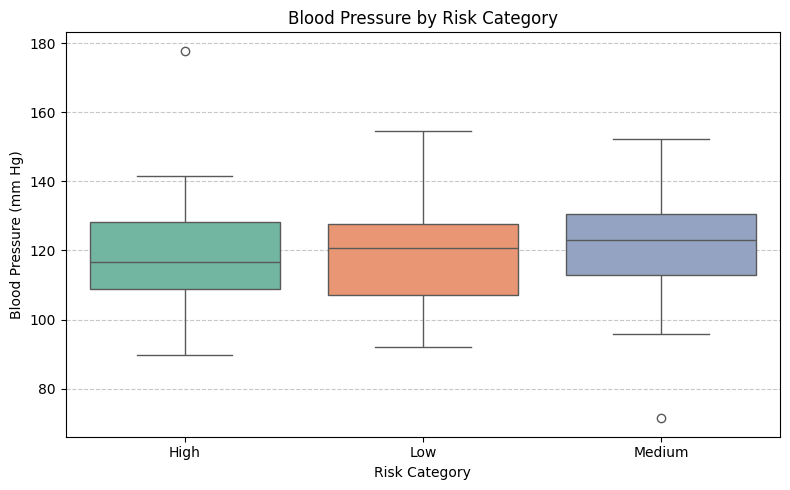

In [27]:
# Generate a box plot comparing BloodPressure between different RiskCategory levels.
plt.figure(figsize=(8,5))
sns.boxplot(data=df_clean, x = 'RiskCategory', y='BloodPressure', palette='Set2', hue='RiskCategory')

plt.title('Blood Pressure by Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Blood Pressure (mm Hg)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

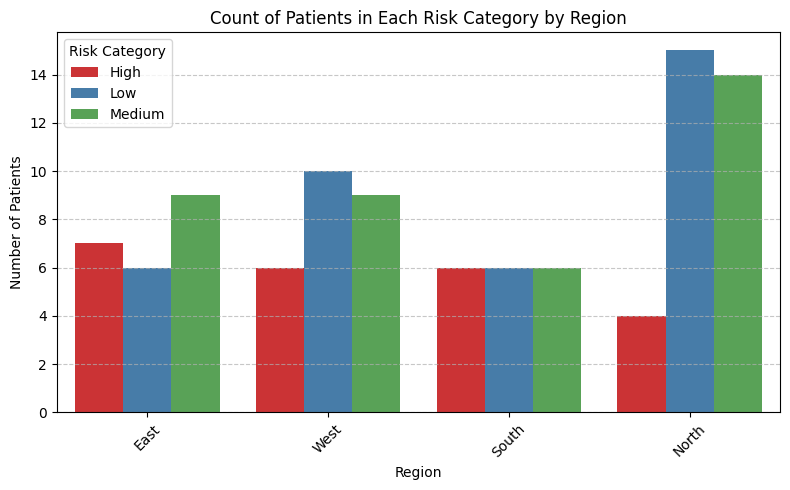

In [28]:
# Create a count plot showing the number of patients in each RiskCategory per Region.
plt.figure(figsize=(8,5))
sns.countplot(data=df_clean, x='Region', hue='RiskCategory', palette='Set1')

plt.title("Count of Patients in Each Risk Category by Region")
plt.xlabel('Region')
plt.ylabel('Number of Patients')
plt.legend(title='Risk Category')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Q3: Statistical Hypothesis Testing


In [31]:
# - Is the average CholesterolLevel significantly different from 200 mg/dL having a sample size of 20?

from scipy.stats import ttest_1samp

# Take a random sample of 20 values
sample = df_clean['CholesterolLevel'].sample(20, random_state=42)

# Perform one-sample t-test against population mean = 200
t_stat, p_value = ttest_1samp(sample, popmean=200)

# Show result
print(f"\033[1mT-Test Result:\033[0m \n T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

# Inference
if p_value < 0.05:
    print("\033[1mInference:\033[0m Reject H0 — The average cholesterol level is significantly different from 200 mg/dL.")
else:
    print("\033[1mInference:\033[0m Fail to reject H0 — No significant difference from 200 mg/dL.")


T-Test Result: 
 T-Statistic: 1.1450, P-Value: 0.2664
Inference: Fail to reject H0 — No significant difference from 200 mg/dL.


In [32]:
# - Is there a significant relationship between Region and RiskCategory?

from scipy.stats import chi2_contingency

# Creating a contigency table
contingency_table = pd.crosstab(df_clean['Region'], df_clean['RiskCategory'])

# Observed Values
print("\033[1mOberserved Values\033[0m:")
display(contingency_table.values)


# Performing Chi-sqaure test
chi2 , p_val, dof, expected = chi2_contingency(contingency_table)

# results
print(f"\n\033[1mChi-square Test Result:\033[0m\nChi-Sqaure Statistic: {chi2:.4f}, P_Value: {p_val}, Degrees of Freedom: {dof}")


# Conclusion
if p_val < 0.05:
    print("\033[1mInference:\033[0m Reject H0 i.e There is a significant relationship between Region & Risk Category.")
else:
    print("\033[1mInference:\033[0m Failed to reject H0 i.e There is not significant relationship between Region & Risk Category.")

Oberserved Values:


array([[ 7,  6,  9],
       [ 4, 15, 14],
       [ 6,  6,  6],
       [ 6, 10,  9]])


Chi-square Test Result:
Chi-Sqaure Statistic: 4.8247, P_Value: 0.5664877563797075, Degrees of Freedom: 6
Inference: Failed to reject H0 i.e There is not significant relationship between Region & Risk Category.


# Q4: Modeling a Health System with ODE

In [38]:
# Defining the ODE system
from scipy.integrate import odeint, solve_ivp


# Constants 
k =0.1
D = 100

# ODE function
def dc_dt(C, t):
    return k * (D-C)


# Solving using odeint

# time vector 
t = np.linspace(0,50,200)

# initial condition
C0 = 0

# Solve ODe
c_odeint = odeint(dc_dt, C0, t)

In [39]:
# Solving using solve_ivp

def dc_dt_ivp(t,C):
    return k * (D - C)

# Solve ODE
sol_ivp = solve_ivp(dc_dt_ivp, t_span=[0,50], y0=[0], t_eval=t)
# print(sol_ivp)

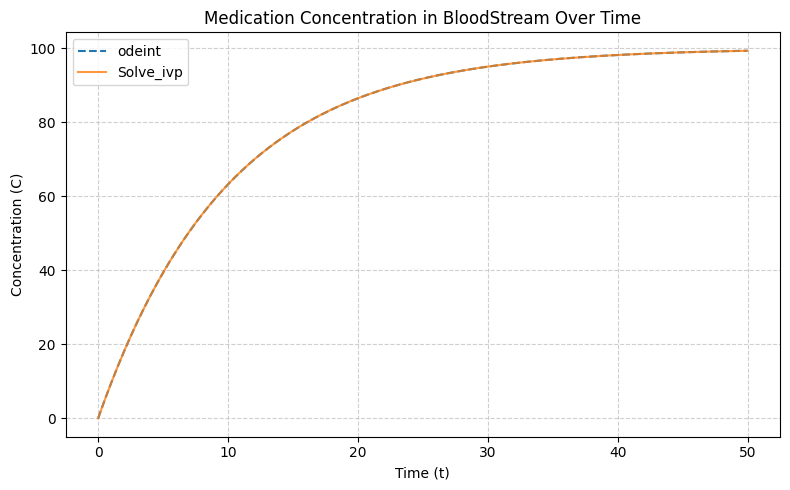

In [40]:
# Plotting Both results
plt.figure(figsize=(8,5))

# ploting odeint
plt.plot(t,c_odeint, label='odeint', linestyle='--')

# Plot Solve_ivp
plt.plot(sol_ivp.t, sol_ivp.y[0], label='Solve_ivp', alpha=0.8)

plt.title("Medication Concentration in BloodStream Over Time")
plt.xlabel("Time (t)")
plt.ylabel("Concentration (C)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()